# CIFAR10 Classification

<img src="CIFAR10_data_overview.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px">

## Import required packages

In [1]:
# Import packages 
import os
import pathlib
from datetime import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import wandb

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Loading & Normalizing CIFAR10

In [2]:
def get_dataloaders(batch_size):

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])


    data_path = 'training_data_cifar10/cifar10_data/'

    trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            
    return trainloader, testloader, classes

## Visualization of the dataset

Files already downloaded and verified
Files already downloaded and verified


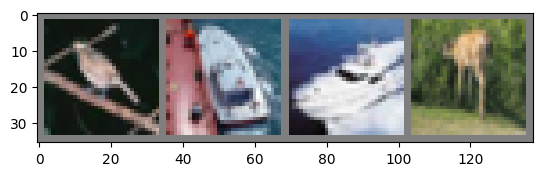

 bird  ship  ship  deer


In [3]:
# Functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train, test, classes = get_dataloaders(batch_size = 16)
# Get some random training images
dataiter = iter(train)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Defining 2 Neural Networks (for experimentation purposes)

In [4]:
# Define Resnet using default weights
net_1 = torchvision.models.resnet50(weights = "DEFAULT")
net_1.name = "resnet50"

# Set the model to run on the device
net_1 = net_1.to(device)

In [5]:
# Define Densenet using default weights
net_2 = torchvision.models.densenet121(weights = "DEFAULT")
net_2.name = "densenet121"

# Set the model to run on your device
net_2 = net_2.to(device)

## Training Model

In [6]:
def train(wandb_config=None):
    # Initialize the run with configs above on WandB
    run = wandb.init(project="cifar10-project", 
                         config=wandb_config)

    if run.config.model == "resnet50":
        model = net_1
    elif run.config.model == "densenet121":
        model = net_2
    else:
        raise ValueError(f"Model name {run.config.model} does not exist")

    trainloader, tesloader, classes = get_dataloaders(run.config.batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=run.config.learning_rate, momentum=run.config.momentum)

    # Training
    for epoch in range(10):  # loop over the dataset

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # Use those GPUs!
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_acc = 100 * correct // total

            # Print statistics
            running_loss += loss.item()

            if i % 200 == 199:    # Print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

        wandb.log({'epoch': epoch, 'accuracy': train_acc, 'loss': loss.item()})

        print('Finished Training')

In [7]:
# Configuration

learning_rate = 0.01
momentum = 0.9
batch_size = 32
model = net_1

config = {"batch_size": batch_size,
         "learning_rate": learning_rate,
         "momentum": momentum,
         "model": model.name}

train(config)

wandb: Currently logged in as: ekin. Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified


## It is 'Sweep' o'clock!

In [16]:
sweep_configuration = {
    'method': 'random',
    'metric': 
    {
        'goal': 'minimize', 
        'name': 'accuracy'
        },
    'parameters': 
    {
        'learning_rate': {'max': 0.1, 'min': 0.001},
        'batch_size': {'values': [8, 16, 32]},
     }
}


In [17]:
sweep_id = wandb.sweep(
    sweep=sweep_configuration, 
    project='cifar10-project'
    )

Create sweep with ID: jtnnchpw
Sweep URL: https://wandb.ai/ekin/cifar10-project/sweeps/jtnnchpw


In [18]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: s2ophi29 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.02042073141416543
wandb: Currently logged in as: ekin. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[1,   200] loss: 3.390
[1,   400] loss: 2.255
[1,   600] loss: 2.070
[1,   800] loss: 1.969
[1,  1000] loss: 1.946
[1,  1200] loss: 1.906
[1,  1400] loss: 1.836
[1,  1600] loss: 1.895


wandb: Ctrl + C detected. Stopping sweep.


## Testing our Model

In [ ]:
# Testing the performance of the model on test set
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %
